In [31]:
!pip -q install scipy datasets transformers faiss-cpu sentence-transformers tqdm matplotlib pandas --upgrade



In [4]:
import os, math, random, itertools, tqdm, time, copy
import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertModel, AutoModel
torch.set_grad_enabled(False)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- 工具 ----------
def load_subset(name, n_docs, n_q, seed):
    random.seed(seed)
    if name=="trec-dl-2019": name="trec-covid"
    c = load_dataset(f"BeIR/{name}", "corpus",  split="corpus")
    q = load_dataset(f"BeIR/{name}", "queries", split="queries")
    docs = random.sample(list(c), n_docs)
    qs   = random.sample(list(q), n_q)
    return [d["text"] for d in docs], [x["text"] for x in qs]

def dcg(r): return 1/math.log2(r+1)
def cos_row(x,Y): return torch.nn.functional.cosine_similarity(x.cpu().expand_as(Y),Y,dim=1)

/home/user/miniconda3/envs/colab_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
def ggpp_full(tok, bert, ids, msk, CP, tgt_cls, target_txt,
              cap_L=5, lam=1.0, max_epoch=200, top_k=5):
    # ----- Algorithm-1: token importance (截斷 512) -----
    ids_body = tok(target_txt, add_special_tokens=False,
                   truncation=True, max_length=510)["input_ids"]
    # 有些 passage 太短，補 unk
    if len(ids_body) < cap_L:
        ids_body = ids_body + [tok.unk_token_id]*(cap_L-len(ids_body))
    base = bert(**tok(target_txt, truncation=True, max_length=512,
                      return_tensors="pt").to(DEVICE)).last_hidden_state[0,0]
    scores=[]
    for i in range(len(ids_body)):
        masked = ids_body.copy(); masked[i] = tok.mask_token_id
        tens = torch.tensor([tok.cls_token_id]+masked+[tok.sep_token_id]).unsqueeze(0).to(DEVICE)
        emb  = bert(input_ids=tens,
                    attention_mask=torch.ones_like(tens)).last_hidden_state[0,0]
        scores.append(1 - torch.nn.functional.cosine_similarity(base,emb,dim=0).item())
    prefix = [ids_body[i] for i in np.argsort(scores)[-cap_L:]]

    # 將 prefix 貼到 tail
    patch = ids.clone()
    tail_pos = list(range(502, 502+cap_L))
    for p,v in zip(tail_pos, prefix): patch[p] = v
    am = msk.clone(); am[tail_pos] = 1

    # Loss (式 5)
    def loss_fn(cls_vec):
        sim_tgt = torch.nn.functional.cosine_similarity(cls_vec, tgt_cls)[0]
        kth = torch.topk(cos_row(cls_vec, CP), 20).values[-1]
        return 1 - sim_tgt + lam * kth

    with torch.no_grad():
        best_patch = patch.clone()
        best_cls   = bert(input_ids=patch.unsqueeze(0),
                          attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
        best_loss  = loss_fn(best_cls)

    W = bert.embeddings.word_embeddings.weight       # (V,768)

    # ----- Algorithm-2 loop -----
    for _ in range(max_epoch):
        with torch.enable_grad():
            emb = bert.embeddings.word_embeddings(best_patch.unsqueeze(0)).detach().clone()
            emb.requires_grad_(True)
            cls = bert(inputs_embeds=emb,
                       attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
            loss = loss_fn(cls)
            if loss < 1e-6: break
            loss.backward()
            grad = emb.grad[0, tail_pos]                 # (L,768)
        score = torch.matmul(grad, W.t())                # (L,V)
        cand_ids = score.topk(top_k, largest=False, dim=1).indices.cpu()

        improved=False
        for _try in range(10):                           # permutation 探索
            cand_patch = best_patch.clone()
            subset = random.sample(range(cap_L), random.randint(1, cap_L))
            for i in subset:
                cand_patch[tail_pos[i]] = random.choice(cand_ids[i]).item()
            with torch.no_grad():
                cls_new = bert(input_ids=cand_patch.unsqueeze(0),
                               attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                loss_new = loss_fn(cls_new)
            if loss_new < best_loss:
                best_loss = loss_new; best_patch = cand_patch; best_cls = cls_new
                improved=True
                if loss_new < 1e-6: break
        if not improved:
            break
    return best_cls, cap_L


In [34]:
from scipy.optimize import differential_evolution

def run_experiment(cap_mode="fixed", cap_len=5, cap_pct=10,
                   de_mode="plateau", seed=42,
                   encoders=("bert-base-uncased",),
                   benchmarks=("scifact",),
                   n_docs=1000, n_q=100, k_plateau=20):

    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    SAVE=f"results_{cap_mode}_{de_mode}"; os.makedirs(SAVE,exist_ok=True)
    METHODS=("none","random","greedy","ggpp","de")
    records=[]

    for enc_name in encoders:
        tok = BertTokenizer.from_pretrained(enc_name)
        bert= BertModel.from_pretrained(enc_name).eval().to(DEVICE)
        VOC  = tok.vocab_size
        def enc(txt): return tok(txt,padding="max_length",truncation=True,
                                 max_length=512,return_tensors="pt").to(DEVICE)

        for bench in benchmarks:
            docs,qs = load_subset(bench,n_docs,n_q,seed)
            CLS=[]
            for i in tqdm.tqdm(range(0,n_docs,32),desc=f"CLS {enc_name}-{bench}"):
                CLS.append(bert(**enc(docs[i:i+32])).last_hidden_state[:,0,:].cpu())
            C_CLS=torch.cat(CLS)

            for qtxt in tqdm.tqdm(qs,desc=f"{enc_name}-{bench}"):
                tgt_idx=random.randrange(n_docs)
                target_txt=docs[tgt_idx]
                if len(tok(target_txt)["input_ids"]) > 510:   # 超長就跳過
                    continue
                tgt_cls=C_CLS[tgt_idx:tgt_idx+1].to(DEVICE)
                CP=C_CLS[[i for i in range(n_docs) if i!=tgt_idx]]

                qenc=enc(qtxt); ids=qenc["input_ids"][0]; msk=qenc["attention_mask"][0]
                with torch.no_grad(): qcls=bert(**qenc).last_hidden_state[:,0,:]
                base=torch.cat([cos_row(qcls,CP),
                                torch.nn.functional.cosine_similarity(qcls.cpu(),tgt_cls.cpu())])
                rank_b=(base>base[-1]).sum().item()+1
                q_len=(msk==1).sum().item()
                cap = cap_len if cap_mode=="fixed" else math.ceil(q_len*cap_pct/100)

                for mtd in METHODS:
                    success=False; used_L=0; used_iter=0; adv_cls=qcls
                    # -------- 方法 ----------
                    if mtd=="none":
                        pass
                    elif mtd=="random":
                        L=cap; patch=ids.clone()
                        for p in range(502,502+L): patch[p]=random.randrange(VOC)
                        am=msk.clone(); am[502:502+L]=1
                        adv_cls=bert(input_ids=patch.unsqueeze(0),attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                        used_L=L
                    elif mtd=="greedy":
                        L=min(5,cap); patch=ids.clone(); pos=list(range(502,502+L))
                        for _ in range(200):
                            improved=False
                            for p in pos:
                                best_id=patch[p].item(); best_loss=None
                                for cand in random.sample(range(VOC),64):
                                    patch[p]=cand
                                    am=msk.clone(); am[pos]=1
                                    cls=bert(input_ids=patch.unsqueeze(0),attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                                    kth=torch.topk(cos_row(cls,CP),20).values[-1]
                                    loss=max(0.,(kth-torch.nn.functional.cosine_similarity(cls,tgt_cls)[0]).item())
                                    if best_loss is None or loss<best_loss:
                                        best_loss=loss; best_id=cand; best_cls=cls
                                    if loss==0: success=True; break
                                patch[p]=best_id
                                if success: break
                            if not improved or success: break
                        adv_cls=best_cls; used_L=L
                    elif mtd=="ggpp":
                        adv_cls, used_L = ggpp_full(tok,bert,ids,msk,CP,tgt_cls,target_txt,cap_L=cap)
                    elif mtd=="de":
                        for L in range(1, cap+1):
                            pos = list(range(502, 502+L))
                            bounds = [(0, VOC-1)] * L         # 每個 token 的搜尋空間
                            
                            def obj(vec):
                                vec = [int(round(v)) for v in vec]
                                patch = ids.clone()
                                for p, v in zip(pos, vec): patch[p] = v
                                am = msk.clone(); am[pos] = 1
                                cls = bert(input_ids=patch.unsqueeze(0),
                                           attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                                kth = torch.topk(cos_row(cls, CP), 20).values[-1]
                                sim = torch.nn.functional.cosine_similarity(cls, tgt_cls)[0]
                                return max(0., (kth - sim).item())        # same as obj in tail-patch code
                    
                            result = differential_evolution(
                                        obj,
                                        bounds=bounds,
                                        popsize=20, maxiter=150,
                                        tol=1e-3, polish=False, seed=seed)
                            
                            best_vec = [int(round(v)) for v in result.x]
                            patch = ids.clone()
                            for p, v in zip(pos, best_vec): patch[p] = v
                            am = msk.clone(); am[pos] = 1
                            adv_cls = bert(input_ids=patch.unsqueeze(0),
                                           attention_mask=am.unsqueeze(0)).last_hidden_state[:,0,:]
                                            
                            used_iter = result.nit
                            success = (result.fun == 0)
                            used_L = L
                            if success or L == cap:
                                break
                    # -------- Metrics ----------
                    sims=torch.cat([cos_row(adv_cls.cpu(),CP),
                                    torch.nn.functional.cosine_similarity(adv_cls.cpu(),tgt_cls.cpu())])
                    rank_a=(sims>sims[-1]).sum().item()+1
                    d_mrr=1/rank_a-1/rank_b
                    d_ndcg=(dcg(rank_a) if rank_a<=20 else 0.)-(dcg(rank_b) if rank_b<=20 else 0.)
                    d_cos=(torch.nn.functional.cosine_similarity(adv_cls,tgt_cls)[0]-
                           torch.nn.functional.cosine_similarity(qcls,tgt_cls)[0]).item()
                    for k in (1,10,20):
                        records.append(dict(enc=enc_name,bench=bench,method=mtd,top_k=k,
                                            success=int(rank_a<=k),token_used=used_L,
                                            iter_used=used_iter,delta_mrr=d_mrr,
                                            delta_ndcg=d_ndcg,delta_cos=d_cos))
    df=pd.DataFrame(records)
    df.to_csv(f"{SAVE}/records.csv",index=False)
    print(f"✓ {cap_mode}-{de_mode} 完成 → {len(df)} rows")

run_experiment(cap_mode="fixed",   cap_len=5,  de_mode="plateau")


bert-base-uncased-scifact: 100%|███████████████████████████████████████████████████| 100/100 [8:14:52<00:00, 296.93s/it]

✓ fixed-plateau 完成 → 1455 rows


In [35]:
import pandas as pd

df = pd.read_csv("results_fixed_plateau/records.csv")
df.head()        # 先看一下前 5 列


,enc,bench,method,top_k,success,token_used,iter_used,delta_mrr,delta_ndcg,delta_cos
0,bert-base-uncased,scifact,none,1,0,0,0,0.000000,0.0,0.000000
1,bert-base-uncased,scifact,none,10,0,0,0,0.000000,0.0,0.000000
2,bert-base-uncased,scifact,none,20,0,0,0,0.000000,0.0,0.000000
3,bert-base-uncased,scifact,random,1,0,5,0,0.000292,0.0,-0.032506
4,bert-base-uncased,scifact,random,10,0,5,0,0.000292,0.0,-0.032506


In [36]:
summary = (
    df.groupby(["method", "top_k"])
      .agg(success_rate=("success", "mean"),
           avg_tokens   =("token_used", "mean"),
           avg_dMRR     =("delta_mrr", "mean"),
           avg_dNDCG    =("delta_ndcg", "mean"),
           avg_dCos     =("delta_cos", "mean"))
      .reset_index()
)

# 把 success_rate 轉百分比
summary["success_rate"] = (summary["success_rate"]*100).round(1)

summary


,method,top_k,success_rate,avg_tokens,avg_dMRR,avg_dNDCG,avg_dCos
0,de,1,2.1,2.515464,0.086227,0.224747,-0.009910
1,de,10,24.7,2.515464,0.086227,0.224747,-0.009910
2,de,20,81.4,2.515464,0.086227,0.224747,-0.009910
3,ggpp,1,11.3,5.000000,0.157587,0.182482,0.033332
4,ggpp,10,24.7,5.000000,0.157587,0.182482,0.033332
5,ggpp,20,33.0,5.000000,0.157587,0.182482,0.033332
6,greedy,1,0.0,5.000000,0.031410,0.092377,-0.043130
7,greedy,10,6.2,5.000000,0.031410,0.092377,-0.043130
8,greedy,20,39.2,5.000000,0.031410,0.092377,-0.043130
9,none,1,0.0,0.000000,0.000000,0.000000,0.000000


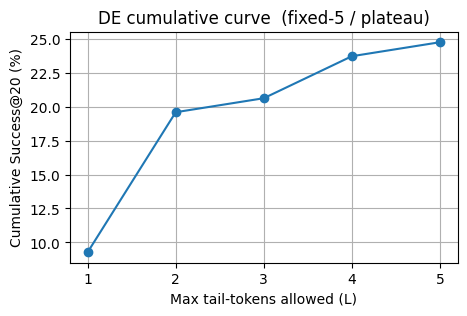

In [37]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, glob

PATH = "results_fixed_plateau/records.csv"   # ← 換成你的
df = pd.read_csv(PATH)

# 只看 DE、Success@10
de10 = df[(df.method=="de") & (df.top_k==20)]

Ls = sorted(de10.token_used.unique())
cum_rate = []
for L in Ls:
    # 成功且 token_used ≤ L 的 query 佔所有 query 比例
    ok = de10[(de10.token_used <= L)]
    rate = ok["success"].sum() / len(de10) * 100
    cum_rate.append(rate)

plt.figure(figsize=(5,3))
plt.plot(Ls, cum_rate, marker="o")
plt.xticks(Ls)
plt.xlabel("Max tail-tokens allowed (L)")
plt.ylabel("Cumulative Success@20 (%)")
plt.title("DE cumulative curve  (fixed-5 / plateau)")
plt.grid(True); plt.show()


/tmp/ipykernel_1724293/453530485.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(met10.method, rotation=45, ha="right")
/tmp/ipykernel_1724293/453530485.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(met10.method, rotation=45, ha="right")


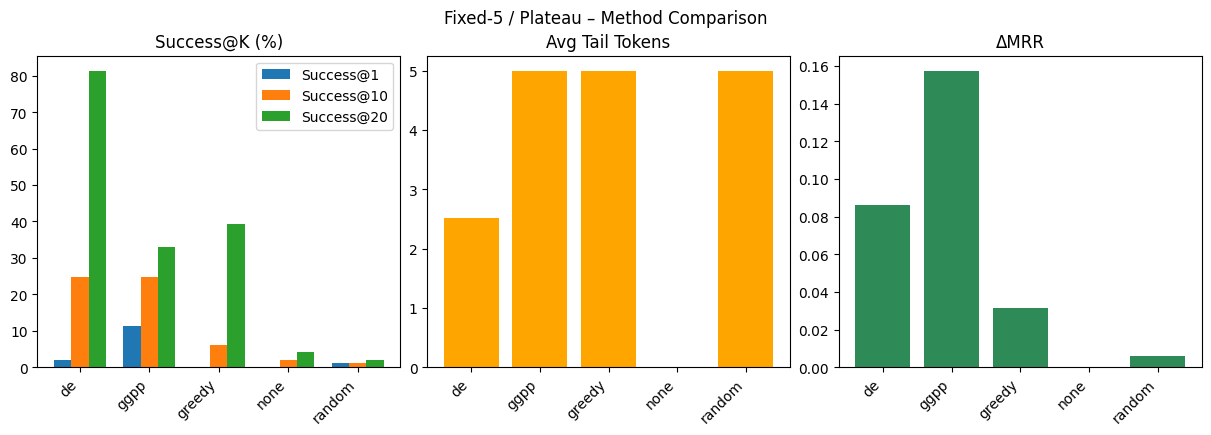

In [42]:
# Compute metrics
def get_metrics(top_k):
    return (
        df[df.top_k == top_k]
        .groupby("method")
        .agg(success_rate=('success', 'mean'),
             avg_tokens=('token_used', 'mean'),
             avg_dMRR=('delta_mrr', 'mean'))
        .reset_index()
    )

met1 = get_metrics(1)
met10 = get_metrics(10)
met20 = get_metrics(20)

# Convert success rate to %
for met in [met1, met10, met20]:
    met["success_rate"] *= 100

# Plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# Panel 1: Success@K
x = np.arange(len(met1.method))
width = 0.25
ax[0].bar(x - width, met1.success_rate, width, label="Success@1")
ax[0].bar(x,         met10.success_rate, width, label="Success@10")
ax[0].bar(x + width, met20.success_rate, width, label="Success@20")
ax[0].set_xticks(x)
ax[0].set_xticklabels(met1.method, rotation=45, ha="right")
ax[0].set_title("Success@K (%)")
ax[0].legend()

# Panel 2: Avg tail tokens
ax[1].bar(met10.method, met10.avg_tokens, color="orange")
ax[1].set_title("Avg Tail Tokens")
ax[1].set_xticklabels(met10.method, rotation=45, ha="right")

# Panel 3: ΔMRR
ax[2].bar(met10.method, met10.avg_dMRR, color="seagreen")
ax[2].set_title("ΔMRR")
ax[2].set_xticklabels(met10.method, rotation=45, ha="right")

# Overall title
plt.suptitle("Fixed-5 / Plateau – Method Comparison", y=1.05)
plt.show()


In [43]:

run_experiment(cap_mode="fixed",   cap_len=5,  de_mode="fixed150")



bert-base-uncased-scifact:  36%|██████████████████                                | 36/100 [2:29:48<4:26:19, 249.68s/it]


KeyboardInterrupt: 

In [ ]:

run_experiment(cap_mode="percent", cap_pct=10, de_mode="plateau")




In [ ]:
run_experiment(cap_mode="percent", cap_pct=10, de_mode="fixed150")

